In [21]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')

In [88]:
import numpy as np
from kernellib.gpr import fit_gp
from sklearn.datasets import load_boston
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


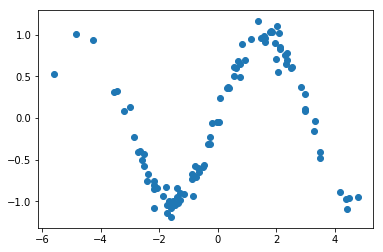

In [120]:
seed = 123
rng = np.random.RandomState(seed)
n_train, n_test = 100, 500
d_dimensions = 1
noise = 0.1

xtrain = 2 * rng.randn(n_train, d_dimensions)
ytrain = np.sin(xtrain) + noise * rng.randn(n_train, d_dimensions)

xplot = np.linspace(xtrain.min(), xtrain.max(), n_test)[:, np.newaxis]
ytest = np.sin(xtest)


fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain)

plt.show()

## Kernel Ridge Regression (ARD Kernel)

In [255]:
param_grid = {
    'alpha': [1e1, 1e0, 1e-1, 1e-2, 1e-3],
    'gamma': np.logspace(-2, 2,10)
}

grid_clf = GridSearchCV(KernelRidge(kernel='rbf'), param_grid=param_grid, n_jobs=10)
grid_clf.fit(xtrain, ytrain)
krr_model = grid_clf.best_estimator_

In [256]:
print(krr_model)

KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=0.21544346900318834,
      kernel='rbf', kernel_params=None)


In [257]:
krr_model = KRR(kernel='rbf', alpha=alpha, gamma=gamma)
krr_model.fit(xtrain, ytrain)
y_pred = krr_model.predict(xplot)

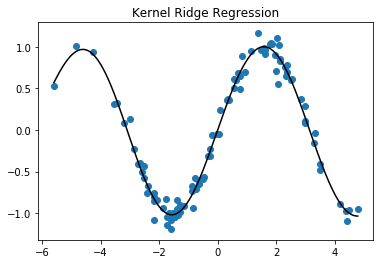

In [274]:
fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain)
ax.plot(xplot, y_pred, color='k')
ax.set_title('Kernel Ridge Regression')
plt.show()

### Derivative and Sensitivity

In [259]:
from kernellib.derivatives import RBFDerivative

In [260]:
der_model = RBFDerivative(krr_model)

# Calculate the Derivative (M x D)
der = der_model.derivative(xplot)
print('Derivative shape:', der.shape)

# Calculate the Full Derivative (N x M x D)
full_der = der_model.derivative(xplot, full=True)
print('Full Derivative shape:', der.shape)


# Per Point Sensitivity
per_point_sens = der_model.point_sensitivity(xplot, sample='point')
print('Per Point Sens shape:', per_point_sens.shape)

# Per Dimension Sensitivity
per_dim_sens = der_model.point_sensitivity(xplot, sample='dim')
print('Per Dim Sens:', per_dim_sens)

# Total Senstivity
sens = der_model.sensitivity(xplot)
print('Total Sens: {:.3f}'.format(sens))

Derivative shape: (500, 1)
Full Derivative shape: (500, 1)
Per Point Sens shape: (500,)
Per Dim Sens: [0.48306066]
Total Sens: 0.483


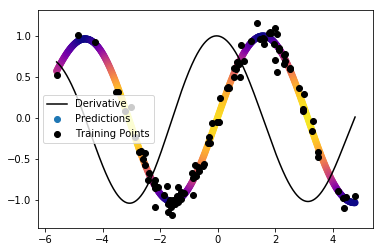

In [261]:
fig, ax = plt.subplots()

ax.scatter(xplot, y_pred, c=per_point_sens[:, np.newaxis], 
           label='Predictions', cmap=plt.cm.plasma)
ax.scatter(xtrain, ytrain, color='k', label='Training Points')

ax.plot(xplot, der, color='k', label='Derivative')

ax.legend()
ax.set_title('Kernel Ridge Regression')
plt.show()

## Gaussian Processes (ARD Kernel)

In [264]:
from sklearn.gaussian_process.kernels import (ConstantKernel as C,
                                              RBF, WhiteKernel)
from sklearn.gaussian_process import GaussianProcessRegressor

In [271]:
kernel = C() * RBF() + WhiteKernel()
gp_model = GaussianProcessRegressor(kernel=kernel, random_state=seed)

gp_model.fit(xtrain, ytrain);
y_pred = gp_model.predict(xplot)

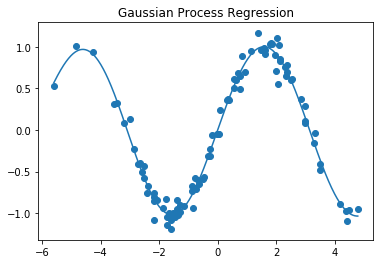

In [301]:
fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain)
ax.plot(xplot, y_pred)
ax.set_title('Gaussian Process Regression')

plt.show()

## Derivative and Sensitivity

In [284]:
from kernellib.derivatives import ARDDerivative

In [285]:
der_model = ARDDerivative(gp_model)

# Calculate the Derivative (M x D)
der = der_model.derivative(xplot)
print('Derivative shape:', der.shape)

# # Calculate the Full Derivative (N x M x D)
# full_der = der_model.derivative(xplot, full=True)
# print('Full Derivative shape:', der.shape)


# Per Point Sensitivity
per_point_sens = der_model.point_sensitivity(xplot, sample='point')
print('Per Point Sens shape:', per_point_sens.shape)

# Per Dimension Sensitivity
per_dim_sens = der_model.point_sensitivity(xplot, sample='dim')
print('Per Dim Sens:', per_dim_sens)

# Total Senstivity
sens = der_model.sensitivity(xplot)
print('Total Sens: {:.3f}'.format(sens))

Derivative shape: (500, 1)
Per Point Sens shape: (500,)
Per Dim Sens: [0.48412956]
Total Sens: 0.484


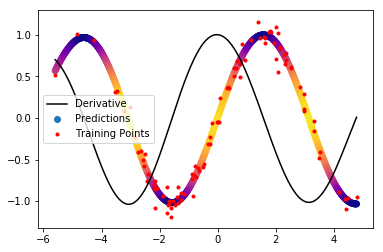

In [300]:
fig, ax = plt.subplots()

ax.scatter(xplot, y_pred, c=per_point_sens[:, np.newaxis], 
           label='Predictions', cmap=plt.cm.plasma)
ax.scatter(xtrain, ytrain, color='r', s=9.0, label='Training Points')

ax.plot(xplot, der, color='k', label='Derivative')

ax.legend()
ax.set_title('Gaussian Processes Regression')

plt.show()

## 2D Example

In [315]:
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [413]:
# Preparing some parameters (just to create the example data)
x = np.array([[x1,x2] for x1 in range(40) for x2 in range(40)]) # 2d sim input (no need to be a neat grid in practice)
w = np.array([5.0,2.0])   # GP bandwidth parameter for each dimension

signal_variance = 2         # GP variance parameter
vt = 0.01                   # GP variance of the error epsilon

mean = 0.0 * np.zeros(x.shape[0])
rng = np.random.RandomState(seed=123)

ard_kernel = C(signal_variance) * RBF(length_scale=w)
K = ard_kernel(x)
y = rng.multivariate_normal(mean, cov=K)
print(x.shape, y.shape)

(1600, 2) (1600,)


In [414]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.2, random_state=seed)
print(xtrain.shape, xtest.shape)

(320, 2) (1280, 2)


/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


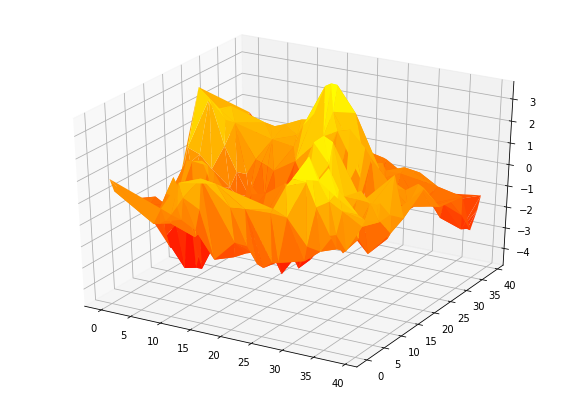

In [415]:

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.plot_trisurf(xtrain.T[0],xtrain.T[1], ytrain, cmap=cm.autumn, linewidth=0.2)
# ax.plot_trisurf(x_new.T[0],x_new.T[1],means, cmap=cm.winter, linewidth=0.2)
plt.show()

#### Kernel Ridge Regression

In [416]:
%%time 
param_grid = {
    'alpha': [1e1, 1e0, 1e-1, 1e-2, 1e-3],
    'gamma': np.logspace(-2, 2,10)
}

grid_clf = GridSearchCV(KernelRidge(kernel='rbf'), param_grid=param_grid, n_jobs=10)
grid_clf.fit(xtrain, ytrain)
krr_model = grid_clf.best_estimator_
print(krr_model)

KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=0.0774263682681127,
      kernel='rbf', kernel_params=None)
CPU times: user 250 ms, sys: 958 ms, total: 1.21 s
Wall time: 2.32 s


In [417]:
krr_model = KRR(kernel='rbf', alpha=alpha, gamma=gamma)
krr_model.fit(xtrain, ytrain)
y_pred = krr_model.predict(x)

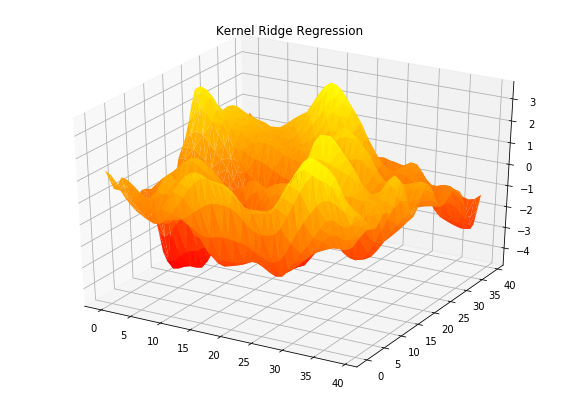

In [418]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.plot_trisurf(x.T[0],x.T[1], y_pred, cmap=cm.autumn, linewidth=0.2)
ax.set_title('Kernel Ridge Regression')
plt.show()

In [419]:
der_model = RBFDerivative(krr_model)

# Calculate the Derivative (M x D)
der = der_model.derivative(x)
print('Derivative shape:', der.shape)

# # Calculate the Full Derivative (N x M x D)
# full_der = der_model.derivative(x, full=True)
# print('Full Derivative shape:', der.shape)


# Per Point Sensitivity
per_point_sens = der_model.point_sensitivity(x, sample='point')
print('Per Point Sens shape:', per_point_sens.shape)

# Per Dimension Sensitivity
per_dim_sens = der_model.point_sensitivity(x, sample='dim')
print('Per Dim Sens:', per_dim_sens)

# Total Senstivity
sens = der_model.sensitivity(x)
print('Total Sens: {:.3f}'.format(sens))

Derivative shape: (1600, 2)
Per Point Sens shape: (1600,)
Per Dim Sens: [0.09010563 0.5460784 ]
Total Sens: 0.318


### Gaussian Processes

In [420]:
from sklearn.gaussian_process.kernels import (ConstantKernel as C,
                                              RBF, WhiteKernel)
from sklearn.gaussian_process import GaussianProcessRegressor

In [421]:
%%time 

kernel = C() * RBF() + WhiteKernel()
gp_model = GaussianProcessRegressor(kernel=kernel, random_state=seed)

gp_model.fit(xtrain, ytrain);
y_pred = gp_model.predict(x)

CPU times: user 3.29 s, sys: 27.3 s, total: 30.6 s
Wall time: 652 ms


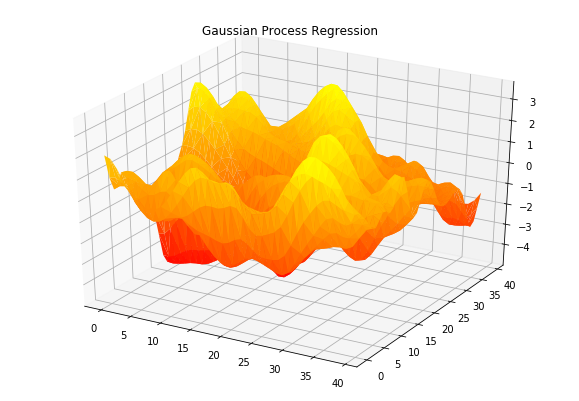

In [422]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.plot_trisurf(x.T[0],x.T[1], y_pred, cmap=cm.autumn, linewidth=0.2)
ax.set_title('Gaussian Process Regression')
plt.show()

In [423]:
der_model = ARDDerivative(gp_model)

# Calculate the Derivative (M x D)
der = der_model.derivative(x)
print('Derivative shape:', der.shape)

# # Calculate the Full Derivative (N x M x D)
# full_der = der_model.derivative(xplot, full=True)
# print('Full Derivative shape:', der.shape)


# Per Point Sensitivity
per_point_sens = der_model.point_sensitivity(x, sample='point')
print('Per Point Sens shape:', per_point_sens.shape)

# Per Dimension Sensitivity
per_dim_sens = der_model.point_sensitivity(x, sample='dim')
print('Per Dim Sens:', per_dim_sens)

# Total Senstivity
sens = der_model.sensitivity(x)
print('Total Sens: {:.3f}'.format(sens))

Derivative shape: (1600, 2)
Per Point Sens shape: (1600,)
Per Dim Sens: [0.09374104 0.64958175]
Total Sens: 0.372


In [424]:
print(x.T[0].shape, x.T[1].shape, y_pred.shape, per_point_sens.shape)

(1600,) (1600,) (1600,) (1600,)


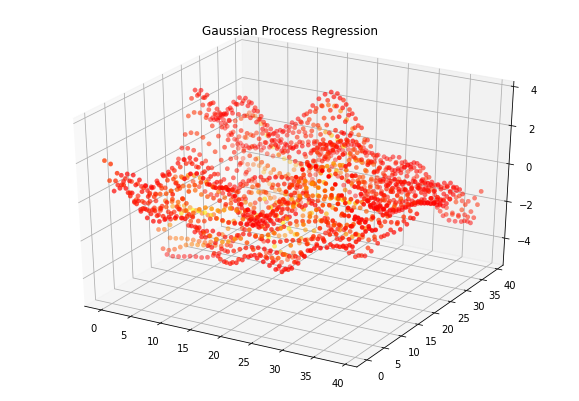

In [427]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.scatter(x.T[0],x.T[1], y_pred, c=per_point_sens, cmap=cm.autumn, linewidth=0.2)
ax.set_title('Gaussian Process Regression')
plt.show()